# Constants

In [1]:
#keyword to be searched
KEYWORD = 'surfing'

# max comments to be scraped
MAX = 100

# import the required stuff

In [2]:
import os
import numpy as np
import pandas as pd
import googleapiclient.discovery # youtube api
import re
from tqdm import tqdm # to get cool progress bar
import nltk
# VADER
from nltk.sentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy


/Users/vicyria/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# !python -m spacy download en_core_web_sm
# nltk.download('vader_lexicon')

In [12]:
# # for google colab
# def get_youtube_object():
#     # file = open("API_KEY",'r')                  #opening the file containg my API key

#     os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

#     api_service_name = "youtube"
#     api_version = "v3"
#     # DEVELOPER_KEY = file.read()                  #reading the API key from the file, did this for security purpose

#     youtube = googleapiclient.discovery.build(
#         api_service_name, api_version, developerKey = "")
#     return youtube
# youtube = get_youtube_object()

In [4]:
def get_youtube_object():
    file = open("/Users/vicyria/Downloads/API_KEY.txt",'r')                  #opening the file containg my API key

    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"
    DEVELOPER_KEY = file.read()                  #reading the API key from the file, did this for security purpose

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey = DEVELOPER_KEY)
    return youtube
youtube = get_youtube_object()

## preprocessing fucntions to create tokens

In [5]:
# a function to chekc if the token we are trying to make is actually a meaningful token
def is_token_allowed(token):
    return bool(token and str(token).strip() and not token.is_stop and not token.is_punct)



# function to preprocess each token at once
# lemmatization -- get the base word out of the token, e.g. "be" is lemma of "was"
# strip of extra space or punctuation
# convert all to lowercase
def preprocess_token(token):
    return token.lemma_.strip().lower()


# final function which will return a string of created tokens
def create_tokens(string):

    # load the english language
    nlp = spacy.load("en_core_web_sm")

    # create an object of spacy library
    nlp_text = nlp(string)
    complete_filtered_tokens = [preprocess_token(token) for token in nlp_text if is_token_allowed(token)]

    # remove if it is of length 1, i.e. emoticons and other symbols etc.
    complete_filtered_tokens = [x for x in complete_filtered_tokens if len(x)>1]

    # return the tokens as one complete string
    complete_filtered_tokens = " ".join(complete_filtered_tokens)
    return complete_filtered_tokens



## class video

In [6]:
class Video: # video class containing all the data associated with each video id containing comments, metaData, channelData
    def __init__(self):
        self.comments = 0
        self.metaData = 0
        self.channelData = 0

    # a function to check if all the functions work or not
    def do_it_all(self):
        # print("kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk")
        self.process_comments()

        self.sentiment_analysis()
        # print(self.comments.head())
        self.process_metaData()
        # print(self.metaData)

#         self.create_commentsCloud()
        # print("kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk")

    # a function to clean and process all the comments and generate tokens from them
    def process_comments(self):
        try:
            # convert 2023-10-21T18:31:54Z to 2023-10-21 18:31:54+00:00
            self.comments["PublishTime"] = pd.to_datetime(self.comments["PublishTime"])

            # create tokens out of comments
            self.comments["tokens"] = self.comments["comments"].apply(create_tokens)

        except Exception as e:
            print(f"error found in Video.process_comments() function: {e}")
    # a function to generate VADER sentiment analysis of the comments -- only to be used after generating tokens using process_comments() function
    def sentiment_analysis(self):
        try:
            SIA=SentimentIntensityAnalyzer()
            results={}
            for i,row in tqdm(self.comments.iterrows()): # iterate through each row of the comments dataset
                text=row["comments"]
                myid=row["commenter"]
                results[myid]=SIA.polarity_scores(text) # get the polarity scores and store in dictionary
            Vaders=pd.DataFrame(results).T
            Vaders= Vaders.reset_index().rename(columns={'index': 'commenter'})
            self.comments=Vaders.merge(self.comments,how='left') # merge and store back in the original variable

            # categorise as positive, negative or neutral based on compound score
            self.comments["sentiment"] = pd.cut(self.comments["compound"], bins=[-1,-0.05,0.05,1], labels=["Negative", "Neutral", "Positive"])

        except Exception as e:
            print(f"error found in Video.sentiment_analysis() function: {e}")

    # function to clean the video metadata
    def process_metaData(self):
        try:
            # removing urls from the video description
            self.metaData["videoDescription"] = re.sub(r"(http.+)|(\n)","",self.metaData["videoDescription"])

            # changing vidLen string into seconds
            k = re.search(r"(?P<hour>\d+H)?(?P<min>\d+M)?(?P<sec>\d+S)",self.metaData["vidLen(sec)"])
            if k:
                hours = int(k["hour"][:-1]) if k["hour"] else 0
                minutes = int(k["min"][:-1]) if k["min"] else 0
                seconds = int(k["sec"][:-1]) if k["sec"] else 0
                self.metaData["vidLen(sec)"] = hours * 3600 + minutes * 60 + seconds
            else:
                print("wrong video duration format")
            
            
            # convert 2023-10-21T18:31:54Z to 2023-10-21 18:31:54+00:00
            self.metaData["videoPublishTime"] = pd.to_datetime(self.metaData["videoPublishTime"])

        except Exception as e:
            print(f"error found in Video.process_metaData() function: {e}")


    # create a word cloud to see the most used words in the comments
    def create_commentsCloud(self, sentiment_type=["Positive", "Negative", "Neutral"]): #cloud for positive negative or neutral
        try:
            words = " ".join(self.comments[self.comments["sentiment"].isin(sentiment_type)]["tokens"])

        except Exception as e:
            print(f"error reported in Video.createCloud {e}")

        word_cloud = WordCloud(collocations = False, background_color = 'white',
                                width = 4096, height = 2048).generate(words)

        plt.imshow(word_cloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()


## class Search

In [7]:
# a search class which contains data about top 5 search results
class Search:
    def __init__(self, keyword, order_by="relevance"):
        request = youtube.search().list(
        part="snippet",
        maxResults=5,
        order=order_by,
        q=keyword,
        type="video"
    )
        response = request.execute()
        self.IDs = {}
        for item in response["items"]:
            self.IDs[item["id"]["videoId"]] = item["snippet"]["channelId"] # keys are video ids and values are channel ids

        self.videos = {}
        for video in self.IDs.keys():
            self.videos[video] = Video()
        self.get_video_meta_data() # a call is made when an instance of search class is created
        self.get_comments() # a call is made when an instance of search class is created
        self.get_channel_meta_data()


    # a function to get top comments[upto MAX] for all the top search results and store as dataframe
    def get_comments(self):
        for vID in tqdm(self.IDs.keys(), "getting comments for each of the top 5 results"):
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=vID, maxResults=100 #,order='time'
            )

            response = request.execute()

            comments = []
            commenter = []
            publishedAt = []
            totalReplyCount = []
            likeCount = []
            for item in response['items']:                  #get all top level comments on the first page of the video
                snippet = item['snippet']['topLevelComment']['snippet']

                comments.append(snippet['textOriginal'])
                commenter.append(snippet['authorDisplayName'])
                publishedAt.append(snippet['updatedAt'])
                likeCount.append(snippet['likeCount'])
                totalReplyCount.append(item['snippet']['totalReplyCount'])

            next_page_token = response.get('nextPageToken')


            while next_page_token is not None:            #getting the comments on the next pages
                if len(comments)>MAX:
                    break
                request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=vID, maxResults=100,
                pageToken = next_page_token
                )
                response = request.execute()

                for item in response['items']:
                    snippet = item['snippet']['topLevelComment']['snippet']

                    comments.append(snippet['textOriginal'])
                    commenter.append(snippet['authorDisplayName'])
                    publishedAt.append(snippet['updatedAt'])
                    likeCount.append(snippet['likeCount'])
                    totalReplyCount.append(item['snippet']['totalReplyCount'])

                next_page_token = response.get('nextPageToken')

            data = {
            "commenter": commenter,
            "comments": comments,
            "PublishTime": publishedAt,
            "totalReplyCount": totalReplyCount,
            "likeCount": likeCount
        }

            self.videos[vID].comments = pd.DataFrame(data)


    # a function to get all the meta data about the video and store as a series
    def get_video_meta_data(self):

        request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        id=list(self.IDs.keys())
        )

        response = request.execute()

        for item in tqdm(response["items"], "getting metadata for the top five videos"):
            dic = {
            "videoId": item["id"],
            "videoTitle": item["snippet"]["title"],
            "videoDescription": item["snippet"]["description"],
            "thumbnail": item["snippet"]["thumbnails"]["medium"]["url"],
#             "channelName": item["snippet"]["channelTitle"],
#             "tags": item["snippet"]["tags"],
            "videoPublishTime": item["snippet"]["publishedAt"],
            "vidLen(sec)": item["contentDetails"]["duration"],
            "viewCount": item["statistics"]["viewCount"],
            "likeCount": item["statistics"]["likeCount"],
            "commentCount": item["statistics"]["commentCount"]
            }

            self.videos[item["id"]].metaData = pd.Series(dic)
#             print(pd.Series(dic))

    def get_channel_meta_data(self):
        
        request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=list(self.IDs.values())
        )
        
        response = request.execute()
        try:
            for item in tqdm(response["items"], "getting metadata for the top five video's channels"):
                dic = {
                "channelId" : item["id"],
                "channelName": item["snippet"]["title"],
                "thumbnail": item["snippet"]["thumbnails"]["medium"]["url"],
#                 "countryOfOrigin": item["snippet"]["country"],
                "viewCount": item["statistics"]["viewCount"],
                "videoCount": item["statistics"]["videoCount"],
                "subscriberCount": item["statistics"]["subscriberCount"]
                }

                for key in self.IDs.keys():
                    if self.IDs[key] == item["id"]:
                        self.videos[key].channelData = pd.Series(dic)
        except Exception as e:
            print(f"unable to fetch channel meta data: {e}")



In [8]:
search = Search(KEYWORD)

getting metadata for the top five videos: 100%|█| 5/5 [00:00<00:00, 2706.00it/s]
getting comments for each of the top 5 results: 100%|█| 5/5 [00:03<00:00,  1.58i
getting metadata for the top five video's channels: 100%|█| 5/5 [00:00<00:00, 15


In [9]:
vid1,vid2,vid3,vid4,vid5 = search.videos.keys()

In [10]:
for vid in search.videos:
    search.videos[vid].do_it_all()

51it [00:00, 8886.61it/s]
120it [00:00, 12619.82it/s]
42it [00:00, 15362.41it/s]
36it [00:00, 10824.01it/s]
13it [00:00, 3521.21it/s]


In [11]:
search.videos[vid1].metaData

videoId                                                   dAIz7xe0Nx4
videoTitle                 Mason Ho | A Week In October | North Shore
videoDescription    Mason Ho arrives home from France and gets str...
thumbnail            https://i.ytimg.com/vi/dAIz7xe0Nx4/mqdefault.jpg
videoPublishTime                            2023-10-27 14:00:32+00:00
vidLen(sec)                                                       807
viewCount                                                       31317
likeCount                                                        1431
commentCount                                                       57
dtype: object

In [12]:
search.videos[vid1].channelData

channelId                                   UCeYue9Nbodzg3T1Nt88E3fg
channelName                                 Ho & Pringle Productions
thumbnail          https://yt3.ggpht.com/ytc/APkrFKZE7SkySzce_Xya...
viewCount                                                   26077333
videoCount                                                       278
subscriberCount                                                83300
dtype: object

In [13]:
search.videos[vid3].metaData

videoId                                                   b7Pl5Rr8ZYk
videoTitle                                The BEST of Surfing in 2022
videoDescription    What a year. 2022 was packed to the gills with...
thumbnail            https://i.ytimg.com/vi/b7Pl5Rr8ZYk/mqdefault.jpg
videoPublishTime                            2023-02-01 19:14:10+00:00
vidLen(sec)                                                        16
viewCount                                                      389433
likeCount                                                       10009
commentCount                                                       42
dtype: object

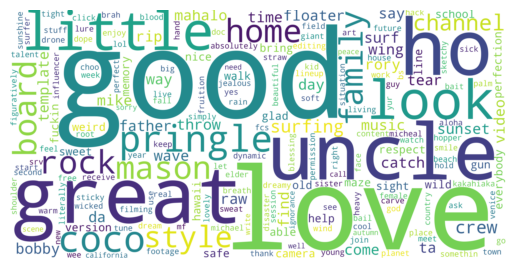

In [14]:
search.videos[vid1].create_commentsCloud(["Positive"])

In [17]:
# !pip install panel


---


# PANELLING

In [49]:
import panel as pn
pn.extension()

youtube_logo = pn.pane.JPG(
    'https://1000logos.net/wp-content/uploads/2021/04/YouTube-logo.png',
    link_url='https://www.youtube.com',
    width=100
)


search_keyword_input = pn.widgets.TextInput(name='Search Youtube', placeholder='Enter a text here...')

search_by = pn.widgets.Select(
    name='Search By', options=["date", "rating", "relevance", "viewCount"])



In [50]:
# getting video thumbnails

vid_thumb = []

for vid in search.videos.values():
    thumb = pn.pane.JPG(
    vid.metaData["thumbnail"],
    link_url=f'https://www.youtube.com/watch?v={vid.metaData["videoId"]}',
    width=270
    )
    
    vid_thumb.append(thumb)
    


In [52]:
# creating the comparison table to be put on the website


# Create an empty DataFrame with the desired column names
columns = ["Published on", "Like count", "Comment count","View Count", "Channel Name", "Total subscribers", "Total channel views","Total Uploaded Videos"]
metaData_df = pd.DataFrame(columns=columns)

# Create an empty list to store rows
rows = []

# Iterate through the videos and add data as rows
for video in search.videos.values():
    row = {
        "Published on": video.metaData["videoPublishTime"],
        "Like count": video.metaData["likeCount"],
        "Comment count" : video.metaData["commentCount"],
        "View Count": video.metaData["viewCount"],
        "Channel Name": video.channelData["channelName"],
        "Total subscribers": video.channelData["subscriberCount"],
        "Total channel views": video.channelData["viewCount"],
        "Total Uploaded Videos": video.channelData["videoCount"]
    }
    rows.append(row)

# Concatenate the list of rows to create the DataFrame
metaData_df = pd.concat([metaData_df, pd.DataFrame(rows)])

# Now, metaData_df contains the video metadata as rows, and you've avoided the deprecated .append method.


# Transpose the DataFrame
metaData_df = metaData_df.T

titles = []
for video in search.videos.values():
    titles.append(video.metaData["videoTitle"])

metaData_df.columns = titles
metaData_df.columns.name = "Video Title"
metaData_df
# Now, metaData_df contains the video metadata with attributes as columns and videos as rows.


/var/folders/5w/t4s77l3x4js5bxj153dkk2zm0000gn/T/ipykernel_49150/3942656354.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metaData_df = pd.concat([metaData_df, pd.DataFrame(rows)])


Video Title,Mason Ho | A Week In October | North Shore,Surfing with his son on his back!❤️😲,The BEST of Surfing in 2022,2ND REEF ROLL INs ALL DAY I Broken Boards Egos & Leashes I Raw Days,6 steps to navigate big & intimidating waves / line ups
Published on,2023-10-27 14:00:32+00:00,2023-09-21 03:00:06+00:00,2023-02-01 19:14:10+00:00,2023-10-27 15:18:46+00:00,2023-10-28 18:30:31+00:00
Like count,1431,3422523,10009,1343,299
Comment count,57,12529,42,84,23
View Count,31317,78783883,389433,59730,20071
Channel Name,Ho & Pringle Productions,Wiry,Red Bull Surfing,Oahu Surf Films,Kale Brock
Total subscribers,83300,371000,274000,2190,196000
Total channel views,26077333,238270994,127182029,531973,28481098
Total Uploaded Videos,278,130,795,204,405


In [53]:
# creating the grid
gspec = pn.GridSpec(sizing_mode='stretch_both', max_height=200)





# Place your components within the grid

gspec[0:2, 0:2] = pn.panel(youtube_logo)
gspec[0, 2:5] = pn.panel(search_keyword_input)
gspec[0, 5] = pn.panel(search_by)






# Create the Panel app with the responsive GridSpec
app = pn.panel(gspec)


In [55]:
# Instantiate the template with widgets displayed in the sidebar
template = pn.template.BootstrapTemplate(
    title='BootstrapTemplate',
    main = app,
    sidebar = [about_us_button],
    theme = "dark"
)
template.main.append(pn.Row(*vid_thumb))  # *image_row: The * symbol before image_row is known as the "splat" operator. It is used to unpack the elements of the image_row list. When we use *image_row, it effectively passes each image pane in the list as a separate argument to the pn.Row function. This is necessary because pn.Row expects its child components to be passed as separate arguments, not as a list.
template.main.append(pn.pane.HTML(metaData_df))

template.show();

Launching server at http://localhost:58541


# About Us Page

In [19]:
def about_us_page(event):
    about_us_text = """
    Welcome to our About Us page! We are a team of dedicated developers working on creating amazing data visualizations with Panel.
    """
    return pn.panel(about_us_text)


In [20]:
about_us_button = pn.widgets.Button(name="About Us")

# def open_about_us(event):
#     return about_us_page()

about_us_button.on_click(about_us_page)


Watcher(inst=Button(name='About Us'), cls=<class 'panel.widgets.button.Button'>, fn=<function about_us_page at 0x16e728b80>, mode='args', onlychanged=False, parameter_names=('clicks',), what='value', queued=False, precedence=0)